### Importing Libraries

In [1]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import librosa
import  warnings
import sounddevice as sd
from scipy.io.wavfile import write
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Flatten, MaxPooling1D, Input
from sincnet_tensorflow import SincConv1D, LayerNorm
from spela.spectrogram import Spectrogram 
from spela.melspectrogram import Melspectrogram
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [5]:
data_dir = 'Voice_Training_Samples/'

In [6]:
os.listdir(data_dir)

['Anveshak-003', 'Darshan-005', 'Dixit-001', 'Sourav-002', 'Vedant-004']

In [7]:
spkr_id = {
    1:'Dixit',
    2:'Sourav',
    3:'Anveshak',
    4:'Vedant',
    5:'Darshan'
}

### Preparing Training Data

In [8]:
def get_wav_paths(speaker):
    speaker_path = data_dir + speaker
    all_paths = [item for item in os.listdir(speaker_path)]
    return all_paths

In [9]:
Dixit_paths = get_wav_paths("Dixit-001")
Sourav_paths = get_wav_paths("Sourav-002")
Anveshak_paths = get_wav_paths("Anveshak-003")
Vedant_paths = get_wav_paths("Vedant-004")
Darshan_paths = get_wav_paths("Darshan-005")

In [10]:
def generate_training_data(speaker_paths, speaker, label):
    wavs, labels = [], []
    for i in tqdm(speaker_paths):
        if str(i).endswith('.wav'):
            wav = load_wav(i, speaker)
            wavs.append(wav)
            labels.append(label)
    return wavs,labels

In [11]:
def load_wav(wav_path,speaker):
    wav_path = data_dir + speaker + '/' + wav_path
    wav_data,_ = librosa.load(wav_path,sr=16000)
    wav_data = wav_data[:112000]
    wav_data = wav_data.tolist()
    return wav_data

In [12]:
Dixit_wavs, Dixit_labels = generate_training_data(Dixit_paths,'Dixit-001',1)
Sourav_wavs, Sourav_labels = generate_training_data(Sourav_paths, "Sourav-002", 2) 
Anveshak_wavs, Anveshak_labels = generate_training_data(Anveshak_paths, "Anveshak-003", 3) 
Vedant_wavs,Vedant_labels = generate_training_data(Vedant_paths,"Vedant-004",4)
Darshan_wavs,Darshan_labels = generate_training_data(Darshan_paths,"Darshan-005",5)

100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


In [13]:
def cvt_lst_arr(wav):
    wav_arr = np.array(wav)
    return wav_arr

In [14]:
Dixit_wavs_arr = cvt_lst_arr(Dixit_wavs)
Sourav_wavs_arr = cvt_lst_arr(Sourav_wavs)
Anveshak_wavs_arr = cvt_lst_arr(Anveshak_wavs)
Vedant_wavs_arr = cvt_lst_arr(Vedant_wavs)
Darshan_wavs_arr = cvt_lst_arr(Darshan_wavs)

In [15]:
train_data = np.concatenate((Dixit_wavs_arr,Sourav_wavs_arr,Anveshak_wavs_arr,Vedant_wavs_arr,Darshan_wavs_arr))
train_labels = Dixit_labels + Sourav_labels + Anveshak_labels + Vedant_labels + Darshan_labels

### Preparing Testing Data

In [16]:
test_dir = 'Voice_Testing_Samples/'

In [17]:
def get_testwav_paths(speaker):
    speaker_path = test_dir + speaker
    all_paths = [item for item in os.listdir(speaker_path)]
    return all_paths

In [18]:
Dixit_test_paths = get_testwav_paths("Dixit-001")
Sourav_test_paths = get_testwav_paths("Sourav-002")
Anveshak_test_paths = get_testwav_paths("Anveshak-003")
Vedant_test_paths = get_testwav_paths("Vedant-004")
Darshan_test_paths = get_testwav_paths("Darshan-005")

In [19]:
def load_wav(wav_path,speaker):
    wav_path = test_dir + speaker + '/' + wav_path
    wav_data,_ = librosa.load(wav_path,sr=16000)
    wav_data = wav_data[:112000]
    wav_data = wav_data.tolist()
    return wav_data

In [20]:
Dixit_test_wavs, Dixit_test_labels = generate_training_data(Dixit_test_paths,'Dixit-001',1)
Sourav_test_wavs, Sourav_test_labels = generate_training_data(Sourav_test_paths, "Sourav-002", 2) 
Anveshak_test_wavs, Anveshak_test_labels = generate_training_data(Anveshak_test_paths, "Anveshak-003", 3) 
Vedant_test_wavs,Vedant_test_labels = generate_training_data(Vedant_test_paths,"Vedant-004",4)
Darshan_test_wavs,Darshan_test_labels = generate_training_data(Darshan_test_paths,"Darshan-005",5)

100%|██████████| 5/5 [00:01<00:00,  3.71it/s]


In [21]:
Dixit_test_arr = cvt_lst_arr(Dixit_test_wavs)
Sourav_test_arr = cvt_lst_arr(Sourav_test_wavs)
Anveshak_test_arr = cvt_lst_arr(Anveshak_test_wavs)
Vedant_test_arr = cvt_lst_arr(Vedant_test_wavs)
Darshan_test_arr = cvt_lst_arr(Darshan_test_wavs)

In [22]:
test_data = np.concatenate((Dixit_test_arr,Sourav_test_arr,Anveshak_test_arr,Vedant_test_arr,Darshan_test_arr))
test_labels = Dixit_test_labels + Sourav_test_labels + Anveshak_test_labels + Vedant_test_labels + Darshan_test_labels

In [23]:
test_label_con = Dixit_test_labels + Sourav_test_labels + Anveshak_test_labels + Vedant_test_labels + Darshan_test_labels

Converting labels to arrays

In [24]:
train_labels = np.array(train_labels)
test_labels =  np.array(test_labels)

Converting label data to categorical form suitable for model

In [25]:
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

### Model Building

In [26]:
sinc_layer = SincConv1D(N_filt=64,
                        Filt_dim=129,
                        fs=16000,
                        stride=16,
                        padding="SAME")


inputs = Input((train_data.shape[1], 1)) 

x = sinc_layer(inputs)
x = LayerNorm()(x)

x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size=2)(x)


x = Conv1D(64, 3, strides=1, padding='valid')(x)
x = BatchNormalization(momentum=0.05)(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(64, 3, strides=1, padding='valid')(x)
x = BatchNormalization(momentum=0.05)(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(128, 3, strides=1, padding='valid')(x)
x = BatchNormalization(momentum=0.05)(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(128, 3, strides=1, padding='valid')(x)
x = BatchNormalization(momentum=0.05)(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

x = Flatten()(x)

x = Dense(256)(x)
x = BatchNormalization(momentum=0.05, epsilon=1e-5)(x)
x = LeakyReLU(alpha=0.2)(x)

x = Dense(256)(x)
x = BatchNormalization(momentum=0.05, epsilon=1e-5)(x)
x = LeakyReLU(alpha=0.2)(x)

prediction = Dense(6, activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=prediction)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112000, 1)]       0         
                                                                 
 sinc_conv1d (SincConv1D)    (None, 7000, 64)          128       
                                                                 
 layer_norm (LayerNorm)      (None, 7000, 64)          128       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7000, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3500, 64)         0         
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 3498, 64)          12352     
                                                             

### Plotting Keras Model layers

In [27]:
model = tf.keras.models.load_model("final-model")
plot_model(model, to_file='model.png')

TypeError: Exception encountered when calling layer "sinc_conv1d_2" (type SincConv1D).

f(x, training, training, training, training, *, training, training) missing 1 required argument: training.

Call arguments received:
  • args=('tf.Tensor(shape=(None, 112000, 1), dtype=float32)',)
  • kwargs={'training': 'False'}

In [ ]:
import visualkeras
visualkeras.layered_view(model,legend=True)
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 20)
figure = plt.figure(figsize=(9,5))
visualkeras.layered_view(model, legend=True, font=font)

TypeError: 'int' object is not iterable

In [28]:
model.compile(optimizer=Adam(learning_rate=0.0001,
                                       beta_1=0.9,
                                       beta_2=0.999,
                                       epsilon=1e-07,
                                       amsgrad=False,
                                       name='Adam'
                                       ),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Model Training

In [29]:
history = model.fit(x=train_data,y=train_labels,epochs=15,validation_data=(test_data,test_labels))

Epoch 1/15
2/2 [==============================] - 5s 598ms/step - loss: 2.0334 - accuracy: 0.2400 - val_loss: 1.0733 - val_accuracy: 0.7308
Epoch 2/15
2/2 [==============================] - 0s 80ms/step - loss: 0.1047 - accuracy: 1.0000 - val_loss: 0.9696 - val_accuracy: 0.6154
Epoch 3/15
2/2 [==============================] - 0s 78ms/step - loss: 0.0299 - accuracy: 1.0000 - val_loss: 0.7291 - val_accuracy: 0.8077
Epoch 4/15
2/2 [==============================] - 0s 83ms/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 1.1164 - val_accuracy: 0.7308
Epoch 5/15
2/2 [==============================] - 0s 84ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.7125 - val_accuracy: 0.8077
Epoch 6/15
2/2 [==============================] - 0s 82ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.6150 - val_accuracy: 0.8077
Epoch 7/15
2/2 [==============================] - 0s 86ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 1.0314 - val_accuracy: 0.6154
Epoch 8/15
2/2 [==========

### Model Evaluation

In [30]:
model.evaluate(test_data,test_labels)

1/1 [==============================] - 0s 129ms/step - loss: 0.7694 - accuracy: 0.7692


[0.7694495320320129, 0.7692307829856873]

### Graphs

#### Accuracy graph

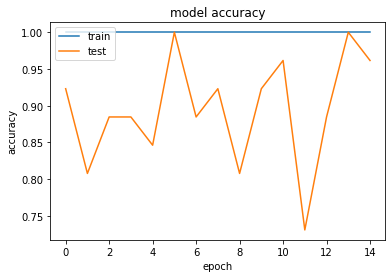

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Loss graph

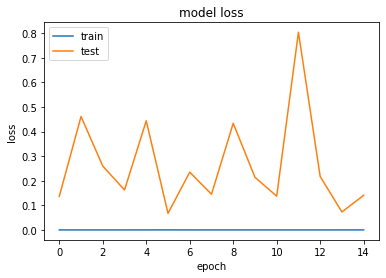

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Confusion Matrix

In [ ]:
load_model = tf.keras.models.load_model("final-model")

In [ ]:
y_pred = load_model.predict(test_data)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 1s 1s/step


In [ ]:
len(y_pred)

26

In [ ]:
y_pred_labels = []
for i in range(len(y_pred)):
    y_label = np.argmax(y_pred[i])
    y_pred_labels.append(y_label)
print(y_pred_labels)

[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5]


In [ ]:
con_mat = tf.math.confusion_matrix(labels=test_label_con, predictions=y_pred_labels).numpy()


In [ ]:
classes = ['Unknown','Dixit','Sourav','Anveshak','Vedant','Darshan']
con_mat_df = pd.DataFrame(con_mat,
                     index = classes, 
                     columns = classes)

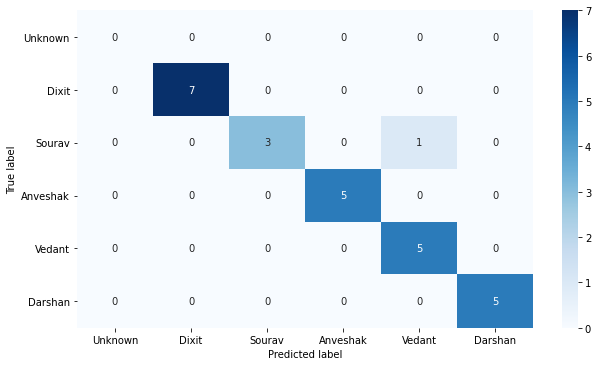

In [ ]:
figure = plt.figure(figsize=(9,5))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(classification_report(test_label_con, y_pred_labels))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         7
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5

    accuracy                           0.96        26
   macro avg       0.97      0.95      0.95        26
weighted avg       0.97      0.96      0.96        26



### Saving Model

In [31]:
model.save("final-model")

INFO:tensorflow:Assets written to: final-model\assets


### New audio files as input to model

In [ ]:
new_audio_files = "C:/Users/Vedant/Desktop/Final Year Project/Sincnet Final/random_samples/"
print(os.listdir(new_audio_files))
model_random_audio = tf.keras.models.load_model("final-model")

new_file = input("Enter any of the above file name: ")
if str(new_file).endswith('.wav'):
    new_file_loc = new_audio_files + new_file
    def test_data_gen(path):
        random_wav,_ = librosa.load(path,sr=16000)
        random_wav = random_wav[:112000]
        random_wav = [random_wav.tolist()]
        random_wav_arr = np.array(random_wav)
        return random_wav_arr
    new_file_arr = test_data_gen(new_file_loc)
    pred_spk = model_random_audio.predict(new_file_arr)
    spkr = np.argmax(pred_spk)
    print("Detected speaker is: ",spkr_id[spkr])
else:
    print("Enter full file name along with extension(.wav)")

['Z1.wav', 'Z2.wav', 'Z3.wav', 'Z4.wav', 'Z5.wav']
Enter any of the above file name: Z3.wav
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 492ms/step
Detected speaker is:  Vedant


#### Live Audio Prediction

In [32]:
def record():
    fs = 44100  # Sample rate
    seconds = 8  # Duration of recording
    source = 'live_audio_record/'
    filename = 'output.wav'
    path = source + filename
    print("Please speak......")
    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
    sd.wait()  # Wait until recording is finished
    write(path, fs, myrecording)  # Save as WAV file 
    print("output.wav succesfully saved in Testing_Audio folder")
    return filename

In [33]:
def cvt_live_audio(path):
    random_wav,_ = librosa.load(path,sr=16000)
    random_wav = random_wav[:112000]
    random_wav = [random_wav.tolist()]
    random_wav_arr = np.array(random_wav)
    return random_wav_arr

In [34]:
spkr_id = {
    1:'Dixit',
    2:'Sourav',
    3:'Anveshak',
    4:'Vedant',
    5:'Darshan'
}

In [39]:
def live_audio_recognition():
    model = tf.keras.models.load_model("final-model")
    print("Model loaded")
    filename = record()
    print("Testing audio: ", filename)
    test_src = "live_audio_record/"
    path = test_src+filename
    random_wav_arr = cvt_live_audio(path)
    print(random_wav_arr)
    predicted_label = model.predict(random_wav_arr)
    print(predicted_label)
    label = np.argmax(predicted_label)
    print(label)
    print(predicted_label[0][label])

    print("Speaker Detected: ",spkr_id[label])

In [40]:
live_audio_recognition()

Model loaded
Please speak......
output.wav succesfully saved in Testing_Audio folder
Testing audio:  output.wav
[[-0.0075913  -0.02596915 -0.030807   ...  0.47535363  0.50742936
   0.52286351]]
[[0.1310573  0.3531886  0.03578583 0.31189546 0.07121586 0.09685688]]
1
0.3531886
Speaker Detected:  Dixit
